In [1]:
import torch
import torch.nn as nn
import pandas as pd
import transformers
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import os
import warnings

warnings.filterwarnings('ignore')
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.8.0+cpu
Transformers version: 4.57.0


In [2]:
class IndoBERTMultiLabel(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.1):
        super(IndoBERTMultiLabel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.classifier(output)
        return logits

In [ ]:
TOKENIZER_DIR = os.path.join('..', 'models', 'model', 'indobert_medicine_classifier_fixed')
CHECKPOINT_PATH = os.path.join('..', 'models', 'model', 'indobert_medicine_classifier_fixed_model.pth')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
print("\nMemuat model dan tokenizer dari file lokal...")

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_DIR)

checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

model_config = checkpoint['model_config']
label_mapping = model_config['label_mapping']
id2label = {int(k): v for k, v in label_mapping['id2label'].items()} 
NUM_LABELS = model_config['num_labels']
MODEL_NAME = model_config['model_name']

model = IndoBERTMultiLabel(MODEL_NAME, NUM_LABELS)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 

print("Model dan tokenizer berhasil dimuat!")


Memuat model dan tokenizer dari file lokal...
Model dan tokenizer berhasil dimuat!


In [ ]:
df = pd.read_csv('../dataset/preprocessed_indobert_data_test.csv', sep=';')

In [6]:
def predict_labels(text, threshold=0.5):
    """Fungsi untuk memprediksi label dari satu teks."""
    if pd.isna(text):
        return 'Teks Kosong'
    
    text = str(text)

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)

    probabilities = torch.sigmoid(logits)
    predictions = (probabilities > threshold).cpu().numpy()
    
    predicted_labels = [id2label[i] for i, label in enumerate(predictions[0]) if label == 1]
    
    return ', '.join(predicted_labels) if predicted_labels else 'Tidak Terklasifikasi'

In [ ]:
if df is not None:
    print("\nMemulai proses prediksi pada data baru...")
    
    tqdm.pandas(desc="Mengklasifikasikan Teks")
    
    if 'text' in df.columns:
        df['jenis'] = df['text'].progress_apply(predict_labels)
        
        print("Proses prediksi selesai!")
        print("\nContoh hasil prediksi:")
        print(df.head())

        OUTPUT_CSV_PATH = 'data_isolation_forest.csv'
        df.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8-sig', sep=';')
        print(f"\nHasil prediksi telah disimpan di: {OUTPUT_CSV_PATH}")

    else:
        print("\n[ERROR] Kolom 'text' tidak ditemukan dalam file Excel.")
        print(f"Kolom yang tersedia: {df.columns.tolist()}")



Memulai proses prediksi pada data baru...


Mengklasifikasikan Teks: 100%|██████████| 6605/6605 [34:59<00:00,  3.15it/s]

Proses prediksi selesai!

Contoh hasil prediksi:
                                                text  06/01/2020 - 12/01/2020  \
0  OBH Surya Itrasal 100 ml - Obat Batuk Hitam In...                        0   
1  OBH Combi Batuk Berdahak Menthol 100Ml OBH Com...                        0   
2  DEGIROL LOZ STRIP 10 TABLET / OBAT RADANG MULU...                        0   
3  ENT Clear powder Packet (20 sachet) Produk ori...                        0   
4  Degirol Tablet Hisap (10 Strip/1 Box) DEGIROL ...                        0   

   13/01/2020 - 19/01/2020  20/01/2020 - 26/01/2020  27/01/2020 - 02/02/2020  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0             

In [9]:
from collections import Counter
print(f"total data: {len(df)}")
all_labels = df["jenis"].str.split(", ").explode() 
label_counts = Counter(all_labels)

print("\nJumlah data per label (multi-label):")
for label, count in label_counts.items():
    print(f"{label}: {count}")

total data: 6605

Jumlah data per label (multi-label):
Ekspektoran: 1128
Herbal: 1433
Antiseptik: 1015
Dekongestan: 955
Antasida: 859
Analgesik: 1208
Antipiretik: 1205
Antidiare: 219
Multivitamin: 1339
Tidak Terklasifikasi: 21


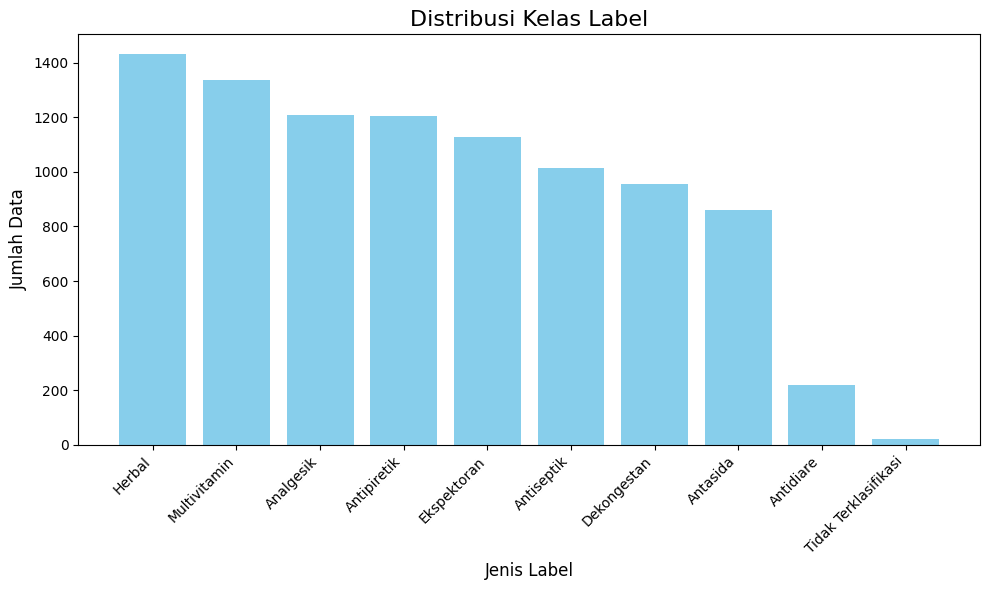

In [ ]:
import matplotlib.pyplot as plt
labels_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(labels_df.index, labels_df['count'], color='skyblue')
plt.title('Distribusi Kelas Label', fontsize=16)
plt.xlabel('Jenis Label', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('distribusi_kelas.png')